# House Price Prediction

This notebook is an introduction to exploratory data analysis and predicting house prices from X using linear regression. First load required Python libraries and data. Then filter out incorrect data. Examine features such as floor space, number of bedrooms, and locations compared to sale price. Finally fit various models and examine fitness scores.

## Data Exploration 

About 50 houses have $0 price. Over 400 houses are above $1M. Best clipping about $5M. One outlier at $25M.

The dataset consists of 4551 houses sold in Washington state between May and July 2014. Most houses are sold during the work week. Examining each zipcode shows large inter-quartile price range, with means above medians meaning there's a skew towards a few expensive houses. Since there's so much variation within the zipcode and city groups, more features are required to accurately predict prices.

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [3]:
houses = pd.read_csv("data/house_data.csv")
houses["state"] = houses["statezip"].str.split().str.get(0)
houses["zipcode"] = houses["statezip"].str.split().str.get(1).astype(int)
houses['date'] = pd.to_datetime(houses["date"])
houses = houses[houses["price"] > 100]
houses = houses[houses["bedrooms"] > 0]
houses["price"] = houses["price"].clip(upper=5000000)
houses["price"] = houses["price"] / 1000
for space in ["living", "lot", "above", "basement"]:
    space = "sqft_" + space
    houses[space] = houses[space] / 1000


In [4]:
def cluter_by_price(df, colname, newname, n_clusters=5):
    zips = df.groupby(colname)["price"].describe()
    kmeans = KMeans(n_clusters=n_clusters)
    zips[newname] = kmeans.fit_predict(zips["50%"].values[:, np.newaxis])
    df = df.merge(zips[newname], left_on=colname, right_index=True)
    return df

In [5]:
houses = cluter_by_price(houses, "zipcode", "zipgroup")
houses = cluter_by_price(houses, "city", "citygroup")

In [6]:
houses["yr_since_built"] = (houses["date"].dt.year - houses["yr_built"])
houses["renovated"] = np.where(houses["yr_renovated"] > 0, 1, 0)
houses["yr_since_renovated"] = (houses["date"].dt.year - houses["yr_renovated"]) * houses["renovated"]
houses["basement"] = np.where(houses["sqft_basement"] > 0, 1, 0)

In [7]:
print(houses.columns.values)
print("Number of (observations, features):", houses.shape)

['date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'waterfront' 'view' 'condition' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'street' 'city' 'statezip' 'country' 'state' 'zipcode'
 'zipgroup' 'citygroup' 'yr_since_built' 'renovated' 'yr_since_renovated'
 'basement']
Number of (observations, features): (4549, 26)


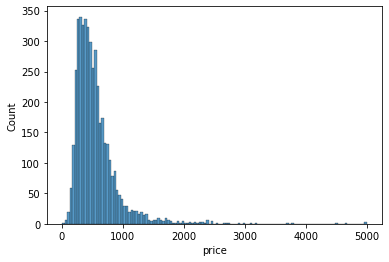

In [8]:
sns.histplot(houses, x="price");

In [9]:
prices = houses["price"].describe()
prices

count    4549.000000
mean      550.689734
std       373.018544
min         7.800000
25%       326.100000
50%       465.000000
75%       657.500000
max      5000.000000
Name: price, dtype: float64

In [10]:
def vis_price(data, feature):
    price_group = data.groupby(feature).describe()["price"]
    price_group.sort_values(by="50%", inplace=True)

    fname = feature.capitalize()
    N = price_group.shape[0]
    fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(6,6))
    plotline, caplines, barlinecols = axs[0].errorbar(x=np.arange(N), y=price_group["50%"], 
                yerr=price_group[["25%", "75%"]].T.values,
                ecolor='gray', label="Median Price")
    axs[0].plot(np.arange(N), price_group["mean"], label="Mean Price")
    axs[0].legend()
    axs[0].set_ylim(bottom=0)
    axs[0].yaxis.set_major_formatter('${x:,.0f}')

    axs[1].plot(np.arange(N), price_group["count"])
    axs[1].set_xlabel(f"{fname} Ordered by Median House Price")
    axs[1].set_ylabel(f"Number of Houses in {fname}")
    return fig, axs

In [11]:
date_sales = houses.groupby("date").describe()["price"]
date_sales["weekday"] = np.where(date_sales.index.day_of_week < 5, 1, -1)

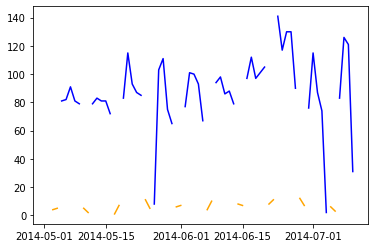

In [12]:
fig, ax = plt.subplots()

def plot_func(group):
    global ax  # refers to ax initialized above
    weekday = (group["weekday"] < 0).all()
    day = "Weekday" if weekday else "Weekend"
    color = 'orange' if weekday else 'blue'
    ax.plot(group.index, group["count"], c=color, label=day)

date_sales.groupby(
    (date_sales['weekday'].shift() * date_sales["weekday"] < 0).cumsum()
).apply(plot_func);

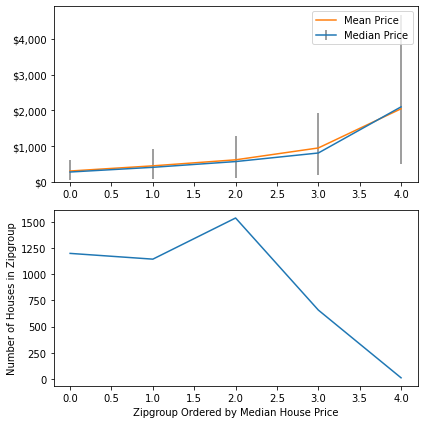

In [13]:
vis_price(houses, "zipgroup");

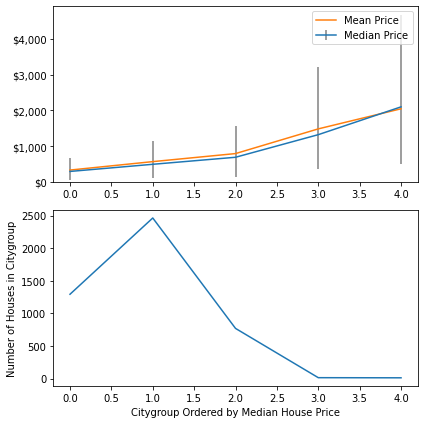

In [14]:
vis_price(houses, "citygroup");

In [15]:
houses.groupby("city")["city"].count().sort_values(ascending=False).head()

city
Seattle     1560
Renton       291
Bellevue     281
Redmond      234
Kirkland     187
Name: city, dtype: int64

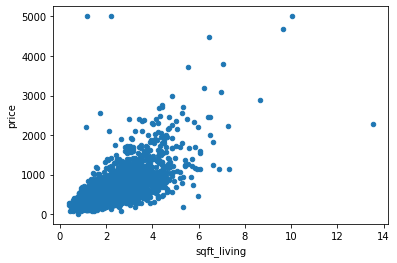

In [16]:
ax = houses.plot.scatter(x="sqft_living", y="price", )

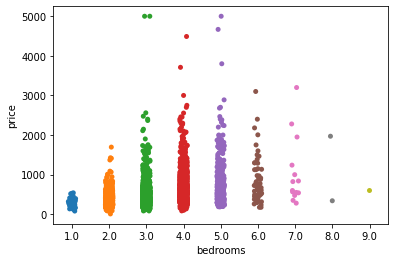

In [17]:
sns.stripplot(data=houses, x="bedrooms", y="price");

<AxesSubplot:xlabel='yr_built'>

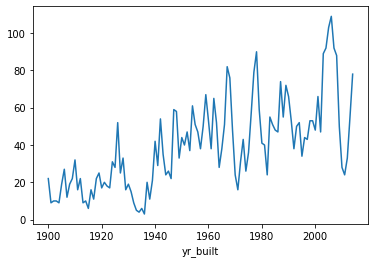

In [18]:
houses.groupby("yr_built")["yr_built"].describe()["count"].plot()

## Prediction with some Feature Engineering

A constant fit model says the average house price is $\hat y =$ $550K with standard deviation $373K. 

One measure of fit is the coefficient of determination

$$
R^2 = 1 - \frac{u}{v}
$$

where $u = \| y - \hat y \|^2$ is the residual (sum of squares) length and $v = \| y - \textbf{avg}(y) \|^2$ is proportional to the total variance. A constant model would always predict $\hat y = \textbf{avg}(y)$ so $u=v$ and $R^2 = 0$. If the residual variance is smaller than the total variance $u < v$, then the model is picking up trends in $y$ and $R^2 > 0$. Increasing $R^2$ means the predictions are correlating with the actual values. Models which overfit a training set and perform poorly on the test set might yield negative $R^2$ because the residual variance is much greater than the observations.

Fitting a linear regression model by

$$
\text{minimize} \quad \| y - X \theta \|^2
$$

minimizes the total residual squared error by a linear combination of the columns of $X$. The first column of $X$ is the intercept. The rest are features which relate $y$ to a linear combination of $\theta$.

To start with, a single feature regression would be on `sqft_living`. The optimal model is $\hat \theta = [-11.3, 263.7]$ with $R^2 = 0.45$. A negative intercept meaning a buyer would *receive* $11K for a house with 0 square feet. Every increase of 1,000 square feet increases the house price by $263K. Prediction with the mean value of 2,132 square feet returns the mean price $550K. 

Next we add bedrooms as a feature. The optimal parameters are $\hat \theta = [100.2, 292.4, -50.9]$, $R^2 = 0.46$, a minor increase in accuracy because living space and bedrooms are highly correlated $\rho = 0.60$. Counter-intuitively adding bedrooms *reduces* the price by $50K. For example, compare two 1,500 sq ft houses with 2 and 3 bedrooms respectively. The model predicts $437K and $386K because squeezing 3 bedrooms into a similar sized space is less desireable. Adding another correlated feature `floors` does not improve scoring, but an uncorrelated feature `waterfront` improves about 2 percentage points.

A knot allows a piecewise linear model to fit the whole range. Setting a know for `sqft_living` at 1,500 sq ft changes the intercept and decreases the slope of the original feature. The knot feature is greater than the orginal, implying houses with more the 1,500 sq ft cost more per square foot.

Finally one-hot encode `zipcode` into 4 clustered types.

In [19]:
houses.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country', 'state', 'zipcode', 'zipgroup', 'citygroup',
       'yr_since_built', 'renovated', 'yr_since_renovated', 'basement'],
      dtype='object')

In [48]:
X = houses.copy(deep=True)
X = X.drop(columns=["date", "country", "state", "city", "statezip", "street", "yr_built", "yr_renovated", "zipcode"])

y = X.pop("price")

X["sqft_1500"] = (X["sqft_living"] - 1.5).clip(0)
X = X.merge(pd.get_dummies(houses["zipgroup"], prefix="zipcode"), left_index=True, right_index=True)
X = X.merge(pd.get_dummies(houses["citygroup"], prefix="city"), left_index=True, right_index=True)
X.drop(columns=["zipgroup", "citygroup"], inplace=True)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,4549.0,3.396131,0.901988,1.000,3.00,3.00,4.00,9.000
bathrooms,4549.0,2.155968,0.775205,0.750,1.75,2.25,2.50,8.000
sqft_living,4549.0,2.131579,0.955235,0.370,1.46,1.97,2.61,13.540
sqft_lot,4549.0,14.834599,35.971144,0.638,5.00,7.68,10.97,1074.218
floors,4549.0,1.511651,0.537794,1.000,1.00,1.50,2.00,3.500
waterfront,4549.0,0.006595,0.080949,0.000,0.00,0.00,0.00,1.000
view,4549.0,0.234337,0.765085,0.000,0.00,0.00,0.00,4.000
condition,4549.0,3.449549,0.675242,1.000,3.00,3.00,4.00,5.000
sqft_above,4549.0,1.821292,0.853292,0.370,1.19,1.59,2.30,9.410
sqft_basement,4549.0,0.310287,0.462043,0.000,0.00,0.00,0.60,4.820


In [22]:
features = X.loc[:, ["sqft_living", "bedrooms", "floors", "waterfront", "sqft_1500", "zipcode_0", 
            "zipcode_1", "zipcode_2", "zipcode_3", "zipcode_4"]]
features.describe().T

,count,mean,std,min,25%,50%,75%,max
sqft_living,4549.0,2.131579,0.955235,0.37,1.46,1.97,2.61,13.54
bedrooms,4549.0,3.396131,0.901988,1.00,3.00,3.00,4.00,9.00
floors,4549.0,1.511651,0.537794,1.00,1.00,1.50,2.00,3.50
waterfront,4549.0,0.006595,0.080949,0.00,0.00,0.00,0.00,1.00
sqft_1500,4549.0,0.721644,0.864159,0.00,0.00,0.47,1.11,12.04
zipcode_0,4549.0,0.144647,0.351783,0.00,0.00,0.00,0.00,1.00
zipcode_1,4549.0,0.251484,0.433914,0.00,0.00,0.00,1.00,1.00
zipcode_2,4549.0,0.002418,0.049120,0.00,0.00,0.00,0.00,1.00
zipcode_3,4549.0,0.263574,0.440620,0.00,0.00,0.00,1.00,1.00
zipcode_4,4549.0,0.337876,0.473038,0.00,0.00,0.00,1.00,1.00


In [78]:
pearson = X.corr()
n = len(pearson)
for i in range(n):
    for j in range(i+1):
        pearson.iloc[j, i] = "-"
pearson = pearson.iloc[1:, :-1]
pearson

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,sqft_1500,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,city_0,city_1,city_2,city_3
bathrooms,0.545645,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
sqft_living,0.601614,0.761544,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
sqft_lot,0.071432,0.109572,0.213313,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
floors,0.18086,0.493975,0.343041,0.004407,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
waterfront,-0.005673,0.063318,0.10793,0.01741,0.015912,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
view,0.117163,0.207231,0.309521,0.072738,0.030236,0.347815,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
condition,0.02199,-0.121796,-0.062042,0.000942,-0.273574,0.006088,0.062897,-,-,-,...,-,-,-,-,-,-,-,-,-,-
sqft_above,0.492056,0.692494,0.875418,0.219352,0.52199,0.072706,0.174506,-0.176119,-,-,...,-,-,-,-,-,-,-,-,-,-
sqft_basement,0.335067,0.295543,0.450709,0.035912,-0.254794,0.088865,0.317633,0.196986,-0.036928,-,...,-,-,-,-,-,-,-,-,-,-
yr_since_built,-0.143019,-0.46586,-0.284498,-0.049157,-0.466823,0.031997,0.066674,0.398773,-0.406412,0.162378,...,-,-,-,-,-,-,-,-,-,-


In [24]:
output = []
szs = [1, 2, 3, 4, 5, 10]
for i in szs:
    ls = LinearRegression(fit_intercept=True)
    X_fold = features.iloc[:, :i]

    ls.fit(X_fold, y)
    ypred = ls.predict(X_fold)
    rss = np.square(ypred - y).sum()
    rms = np.sqrt(rss / len(y))
    coefs = [ls.intercept_]+ls.coef_.tolist()
    coefs += ["-"] * (10-i)
    coefs += [rss, rms, ls.score(X_fold, y)]
    output.append(coefs)

output = pd.DataFrame(output,
        columns=["Intercept"]+features.columns.to_list() + ["RSS", "RMS", "R^2"]
        )
output

,Intercept,sqft_living,bedrooms,floors,waterfront,sqft_1500,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,RSS,RMS,R^2
0,-11.247902,263.625081,-,-,-,-,-,-,-,-,-,3.444090e+08,275.156166,0.455757
1,100.593797,292.699851,-51.180847,-,-,-,-,-,-,-,-,3.382245e+08,272.674542,0.465529
2,91.088995,290.994750,-50.984118,8.250079,-,-,-,-,-,-,-,3.381456e+08,272.642735,0.465654
3,82.690861,281.277041,-44.75022,10.791377,621.621959,-,-,-,-,-,-,3.268613e+08,268.054915,0.483486
4,280.905811,99.974920,-33.37106,16.526829,612.77159,195.370681,-,-,-,-,-,3.229396e+08,266.441997,0.489683
5,584.898115,63.267400,-19.738679,-2.325028,656.760924,176.421445,43.613473,-290.957535,827.251015,-412.321265,-167.585687,2.222774e+08,221.049582,0.648752


Sequentially adding features always improves the training score, although some features a more important than other. For example, adding `floors` does not significantly improve the score, whereas the `zipcode` clusters improve it by over 15%! 

Next we compare model fitting against a held-out test set.

In [25]:
kf = KFold(n_splits=6)

coefs = []
train_mse = []
test_mse = []

for train, test in kf.split(features):
    X_train = X.iloc[train]
    target = y.iloc[train]
    ls.fit(X_train, target)
    coefs.append([ls.intercept_, *ls.coef_])
    train_mse.append(ls.score(X_train, target))
    test_mse.append(ls.score(X.iloc[test], y.iloc[test]))

stats = pd.DataFrame(coefs, columns=["Intercept"]+X.columns.to_list())
stats["Train_Score"] = train_mse
stats["Test_Score"] = test_mse
stats.describe().T

,count,mean,std,min,25%,50%,75%,max
Intercept,6.0,377.449879,144.970901,9.690820e+01,391.445299,408.802895,437.186592,517.878028
bedrooms,6.0,-24.842842,2.305490,-2.776170e+01,-26.804100,-24.341232,-23.033990,-22.389585
bathrooms,6.0,47.678182,5.186903,4.266397e+01,44.261862,46.184691,49.564070,56.724297
sqft_living,6.0,17.470955,9.377683,9.381158e+00,10.535092,14.209250,21.947859,33.188304
sqft_lot,6.0,-0.384872,0.097791,-5.631470e-01,-0.407954,-0.345130,-0.338226,-0.291003
floors,6.0,2.577743,11.620965,-1.266987e+01,-5.286592,1.893068,12.289499,16.275021
waterfront,6.0,473.733175,98.463875,3.311588e+02,426.579233,481.695115,507.262872,623.857275
view,6.0,61.026001,7.365054,5.304028e+01,55.438932,59.542633,67.021240,70.445316
condition,6.0,29.358938,3.411929,2.431991e+01,27.544774,29.853498,30.841150,34.181152
sqft_above,6.0,48.674542,16.110102,3.657720e+01,38.665595,44.726134,48.196223,80.019448


Cross-validation returns a mean test score of $R^2 = 0.64$ and a maximum test score of $R^2=0.74$.

## Subset Feature Selection

Trying out subset selection method. Ridge regression penalizes insignificant feature weights by augmenting the linear model objective

$$
\text{minimize} \quad \| A\theta - y \|^2 + \gamma \| \theta \|^2
$$

when $\gamma$ is large then $\theta$ tends to be small, at the expense of increased residuals. Fitting with Leave-One-Out-Cross-Validation (LOOCV) yields a training score $R^2=0.68$. Not any better than K-fold cross validation.

Text(0.5, 1.0, 'Ridge Regression Coefficients')

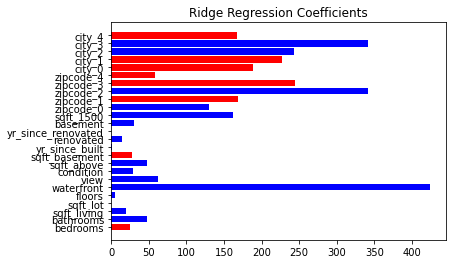

In [71]:
ridge = RidgeCV(alphas=np.logspace(-6, 6), store_cv_values=True).fit(X, y)
importance = np.abs(ridge.coef_)
color = np.where(ridge.coef_ > 0, "blue", "red")
feature_names = X.columns.values
plt.barh(y=feature_names, width=importance, color=color)
plt.title("Ridge Regression Coefficients")

In [76]:
print(ridge.alpha_)
print(ridge.score(X, y))

2.329951810515372
0.684642555396673


Another subset selection technique sequentially adds the most significant features until a stopping criteria is met. This can be done forwards or backwards. Comparing both methods show they find different subsets for the one-hot-encoded areas. Interestingly the subset leaves out `sqft_living` in place of `sqft_lot`, and includes its piecewise linear `sqft_1500` part. Ridge regression gave more significance to `sqft_living` than `sqft_lot`. Highly correlated features might cause this behavior, although the correlation here is 0.21, not too high.

In [53]:
# Selective feature selection
lm = LinearRegression()
sfs = SFS(lm)
sfs.fit(X, y)
feature_mask = sfs.get_support()
X.iloc[:, feature_mask].columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'waterfront', 'view',
       'yr_since_built', 'sqft_1500', 'zipcode_0', 'zipcode_1', 'zipcode_3',
       'city_1', 'city_2'],
      dtype='object')

In [77]:
sfs = SFS(lm, direction="backward")
sfs.fit(X, y)
feature_mask = sfs.get_support()
X.iloc[:, feature_mask].columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'waterfront', 'view',
       'yr_since_built', 'sqft_1500', 'zipcode_1', 'zipcode_3', 'zipcode_4',
       'city_1', 'city_3'],
      dtype='object')

## Conclusion

Loading in a dataset, visualizing it, and model fitting has a standard workflow. Filtering bad data is a judgement call, like removing houses with 0 sqft. Feature engineering is an art as well, requiring strong domain expertise to ask the right questions like "do houses above 1500 sqft cost more per sqft?" Model fitting with linear regression estimates how much sqft costs, or a house on a waterfront. Although adding many features together tangles which features adds most to variance estimation.